### 03 WebサーチをするAIエージェント
#### 03_01 ReAct（Ollama）
gpt-oss:20b＋MCPサーバ構成のため、**Colab GPU は L4 を使用すること。**
- 必要なライブラリをインストール
- Google Colab に Ollama をセットアップ
- ChatOllama で LLM に接続
- MCPサーバ（ddg-search）によるweb検索の実装
- LangGraph による ReAct の実装
- 動作確認

**必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
- NOTE: Colab では uv ではなく pip を使う。
> uv は依存解決の過程で numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [1]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
%pip install -U ollama langchain-ollama \
     "langchain>=1.2.8" "langchain-core>=1.2.8" \
     "langgraph>=1.0.7" \
     "langchain-mcp-adapters>=0.2.1" duckduckgo-mcp-server mcp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.3/496.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.8
    Uninstalling langchain-core-1.2.8:
      Successfully uninstalled langchain-core-1.2.8
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.7
    Uninstalling langgraph-1.0.7:
      Successfully uninstalled langgraph-1.0.7
  Attempting uninstall: langchain
    Found existing installation: langchain 1.2.8
    Uninstalling langchain-1.2.8:
      Successfully uninstalled langchain-1.2.8


**Google Colab に Ollama をセットアップ**
- Ollama のインストール・起動・モデルのダウンロードを行う。
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [2]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


# ReAct エージェントにはツールコール対応モデルが必要。
# NOTE: ollama pull のプログレスバーは Colab で文字化けするため、
#       Python API 経由でステータスのみ表示する。

model_name = "gpt-oss:20b"

for progress in ollama.pull(model_name, stream=True):
    status = progress.get("status", "")
    total = progress.get("total") or 0
    completed = progress.get("completed") or 0
    if total:
        line = f"{status}: {completed / total:.0%}"
    else:
        line = status
    print(f"\r{line:<60}", end="", flush=True)
print("\nDone!")
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
success                                                     
Done!
  Model
    architecture        gptoss    
    parameters          20.9B     
    context length      131072    
    embedding length    2880      
    quantization        MXFP4     

  Capabilities
  

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [3]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

**MCPサーバ（ddg-search）によるweb検索の実装**
- langchain-mcp-adapters の MultiServerMCPClient を使用。
- MCPサーバのツールが自動的に LangChain ツールに変換される（@tool の手動定義が不要）。
- ReAct エージェントが bind_tools() で認識し、自律的にツールを呼び出せる形式になる。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**Colab の stderr 問題の回避（Colab 特有。通常の Python 環境では不要）**

Colab の stderr は fileno() 未対応のため、MCP の stdio_client が失敗する。
stdio_client の関数シグネチャ `errlog=sys.stderr` は**インポート時に評価が確定**するため、
後から sys.stderr を差し替えても効果がない（Python のデフォルト引数の仕様）。
そこで、langchain_mcp_adapters.sessions 内の stdio_client 参照自体を、
errlog のデフォルトを /dev/null に変更したラッパー関数に差し替えて回避する。

**httpx 0.28 互換性の回避（Colab 特有。通常の Python 環境では不要の可能性あり）**

duckduckgo-mcp-server は httpx.TimeoutError を参照するが、依存先の httpx 0.28 で
この属性が削除された（duckduckgo-mcp-server 側のバグ）。
MCP サーバはサブプロセスで動作するため、ノートブック側のパッチが効かない。
そこで、httpx をパッチしてからサーバを起動する Python ラッパー経由で起動する。

In [4]:
# MCPサーバ（duckduckgo-mcp-server）に接続し、LangChainツールを自動取得
# langchain-mcp-adapters が MCP ツールを LangChain 互換に自動変換するため、
# @tool による手動ラップが不要
import os
import sys
import contextlib
from langchain_mcp_adapters import sessions as _sessions  # type: ignore
from langchain_mcp_adapters.client import MultiServerMCPClient  # type: ignore

# --- Colab stderr 問題の回避パッチ（Colab 特有。通常環境では不要） ---
# stdio_client(server, errlog=sys.stderr) のデフォルト値はインポート時に確定する。
# Colab の stderr は fileno() 未対応のため、デフォルトのまま呼ぶと失敗する。
# → errlog のデフォルトを /dev/null に差し替えたラッパーで上書きして回避する。
# NOTE: _devnull はセッション中ずっと開いたままにする（閉じると書き込み先がなくなる）
_devnull = open(os.devnull, "w")
_original_stdio_client = _sessions.stdio_client


@contextlib.asynccontextmanager
async def _patched_stdio_client(server, errlog=_devnull):
    async with _original_stdio_client(server, errlog=errlog) as result:
        yield result


_sessions.stdio_client = _patched_stdio_client


# httpx 0.28 で削除された TimeoutError を復元してからサーバを起動するラッパー
# duckduckgo-mcp-server はサブプロセスで動くため、ノートブック側のパッチが効かない
_MCP_LAUNCHER = (
    "import httpx; "
    "httpx.TimeoutError = getattr(httpx, 'TimeoutError', "
    "type('TimeoutError', (Exception,), {})); "
    "exec(open(__import__('shutil').which('duckduckgo-mcp-server')).read())"
)

mcp_client = MultiServerMCPClient(
    {
        "ddg-search": {
            "transport": "stdio",
            "command": sys.executable,  # python 本体を起動
            "args": ["-c", _MCP_LAUNCHER],  # パッチ付きラッパー
        }
    }
)

# MCP ツールを LangChain ツールとして自動取得
tools = await mcp_client.get_tools()

print("=== ReActエージェント用ツール ===")
for t in tools:
    print(f"  - {t.name}: {t.description}")

=== ReActエージェント用ツール ===
  - search: 
    Search DuckDuckGo and return formatted results.

    Args:
        query: The search query string
        max_results: Maximum number of results to return (default: 10)
        ctx: MCP context for logging
    
  - fetch_content: 
    Fetch and parse content from a webpage URL.

    Args:
        url: The webpage URL to fetch content from
        ctx: MCP context for logging
    


**LangGraph による ReAct エージェントの実装**

ReAct（Reasoning + Acting）は、LLM が以下のループを自律的に繰り返すアーキテクチャ。
1. **Thought（思考）**: 現在の状況を分析し、次に何をすべきか推論する。
2. **Action（行動）**: 必要に応じてツール（Web検索など）を呼び出す。
3. **Observation（観察）**: ツールの結果を受け取り、次の思考に反映する。
4. 十分な情報が得られたら、最終回答を生成する。

LangChain の `create_agent`（旧 LangGraph `create_react_agent`）を使用すると、このループが自動構築される。
- `llm.bind_tools(tools)` で LLM にツール情報を渡し、どのツールを呼べるか認識させる。今回は `create_agent` が内部でこれを行うため、明示的な呼び出しは不要。
- LLM がツールコールを出力 → ツール実行 → 結果を LLM に返却、のサイクルが自動で回る。
- `InMemorySaver` により、スレッドごとに会話履歴を保持する。

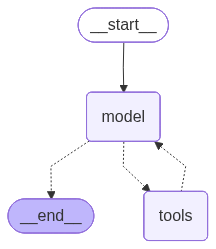

In [5]:
# LangGraph の create_agent で ReAct エージェントを構築
from langchain.agents import create_agent  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from IPython.display import Image, display

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()

# ReAct エージェントの構築
# - model: ツールコール対応の ChatModel（bind_tools が内部で呼ばれる）
# - tools: MCP から自動取得した LangChain ツール（search, fetch_content）
# - checkpointer: 会話履歴の永続化

# システムプロンプトの設定
system_prompt = """
あなたはWeb検索ができるAIアシスタントです。
ユーザの質問に日本語で回答してください。
必要に応じてsearchツールで検索し、詳細が必要ならfetch_contentで内容を取得してください。
最後に結論として、ユーザの質問に対する答えを整理して回答して下さい。

# 結論の回答例
- ユーザの質問
- あなたの回答
"""

# ReActの設定
agent = create_agent(
    model=llm,
    tools=tools,
    checkpointer=memory,
    system_prompt=system_prompt,
)

# 構築したグラフを図示
display(Image(agent.get_graph().draw_mermaid_png()))

**動作確認**
- ReAct エージェントに質問を投げ、自律的に Web 検索 → 回答生成が行われることを確認する。

In [7]:
# ReAct エージェントの動作確認
# MCPツールは非同期専用のため ainvoke を使用する
config = {"configurable": {"thread_id": "react-test"}}

# Web 検索が必要な質問
response = await agent.ainvoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "2025年の日本の総人口は何人ですか？",
            }
        ]
    },
    config=config,
)

print("=== ReAct エージェントの実行結果 ===\n")
for msg in response["messages"]:
    # content がリスト形式の場合、テキスト部分を結合する。
    # NOTE: tool_use 要素等が混在するため type="text" のみ抽出する。
    if isinstance(msg.content, list):
        msg.content = "\n".join(
            item["text"] for item in msg.content if item.get("type") == "text"
        )
    msg.pretty_print()

=== ReAct エージェントの実行結果 ===

================================ Human Message =================================

2025年の日本の総人口は何人ですか？
================================== Ai Message ==================================
Tool Calls:
  search (3999e871-d52f-4a23-a900-d3db883f6d3f)
 Call ID: 3999e871-d52f-4a23-a900-d3db883f6d3f
  Args:
    query: 2025 日本 総人口 推計
    max_results: 10
================================= Tool Message =================================
Name: search

Found 10 search results:

1. 人口推計（2025年（令和7年）8月確定値、2026年（令和8年）1月概算値） （2026年1月20日公表）
   URL: https://www.stat.go.jp/data/jinsui/new.html
   Summary: 各月1日現在の日本の人口について、最新の推計結果を掲載しています。

2. Japan Dashboard
   URL: https://www.japandashboard.com/
   Summary: 日本の人口を"正確な一次データ"で可視化。総務省統計局「人口推計」2025年8月報（2020年国勢調査基準）等をもとに、総人口推移・年齢構成・高齢化・出生率・地域別の実数と構成比を見やすく提供します。

3. 人口統計資料集（2025年版）｜国立社会保障・人口問題研究所
   URL: https://www.ipss.go.jp/syoushika/tohkei/Popular/Popular2025.asp?chap=1
   Summary: 表1－17 人口増加率の高い国，低い国：1950，1980，2025，2100年 図1－1 総人口および人